## A4.1a) Run the MountainCar environment with rescaled states <a id=q1></a>
The Mountaincar environment is challenging because of the exploration behavior, random episodes will rarely see *any* reward before the maximum length is reached, but also because of its extremely unevenly scaled state space: while the car's position is between -1.2 and +0.6, the car's velocity is bounded between -0.07 and +0.07. Run the following experiment, which changes this state space by rescaling each dimension to be between -1 and 1 using the provided `RescaledEnv` wrapper class, for 200k environmental steps. To make sure you propagate rewards fast enough to see a result in that time frame (if there is one), run 10 gradient updates for every sampled episode.

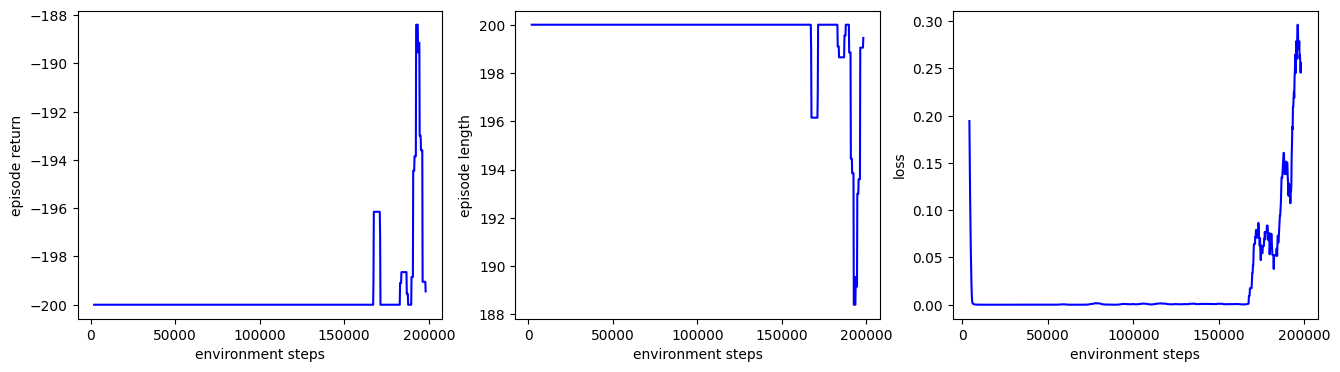

In [15]:
params = default_params()
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = RescaledDQNExperiment(params, model, learner=DoubleQLearner(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A4.1b) Implement intrinsic-reward for deep exploration <a id=q2></a>
To solve the `Mountaincar-v0` environment, you will need to use some deep exploration technique. To test this we will "cheat" a bit at first: use the provided [`CountUncertainty`](#CountUncertainty) class to produce intrinsic reward during training. The class must `observe()` states from newly sampled episodes (make sure each transition in your replay buffer has only been observed once)  and provides a scaled uncertainty estimate with a `()` method call, e.g. `u(state)` for `u = CountUncertainty(...)`. This particular uncertainty class divides the state space into `uncertainty_resolution^m` bins, where `m` is the number of state-dimensions, counts how often observed states fall into these bins and estimates the resulting uncertainty with `uncertainty_scale / sqrt(n)` for n observations of the same states. Complete the implementation of `ExplorationDQNExperiment` and run the `Mountaincar-v0` environment with intrinsic rewards for 200k steps. Make sure that the experiment only uses intrinsic reward if the `intrinsic_reward` parameter is True.

*Hint:*  there are multiple ways to implement intrinsic reward, but the most intuitive is to use the
uncertainty of having seen the *next state* of a transition as additional reward. Make sure that you have
observed those states before you compute their uncertainty, though, as states with observation-counts of
0 produce extremely large uncertainties that can destabilize learning.

In [15]:
class ExplorationDQNExperiment (RescaledDQNExperiment):
    def __init__(self, params, model, learner=None, uncertainty=None, **kwargs):
        super().__init__(params, model, learner, **kwargs)
        self.uncertainty = uncertainty
        self.intrinsic_reward = params.get('intrinsic_reward', True) and uncertainty is not None

    def _learn_from_episode(self, episode):
        if self.intrinsic_reward:
            for i, state in enumerate(episode["buffer"]["states"]):
                self.uncertainty.observe(state)
                episode["buffer"]["rewards"][i] += self.uncertainty(state)
        return super()._learn_from_episode(episode)

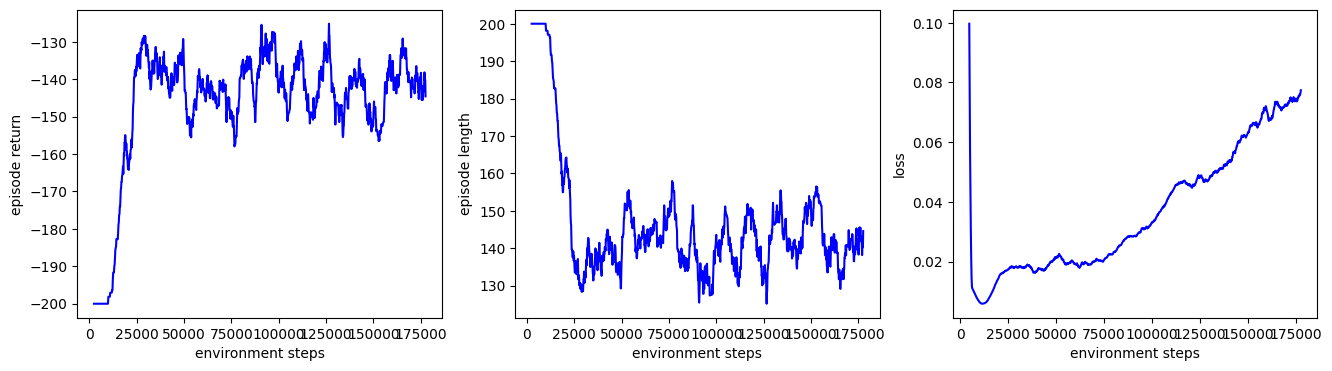

In [17]:

    
params = default_params()
params['intrinsic_reward'] = True
params['uncertainty_scale'] = 0.5
params['uncertainty_resolution'] = 50
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
uncertainty = CountUncertainty(scale=params.get('uncertainty_scale', 1.0), 
                               state_bounds=[(-1,1)] * env.observation_space.shape[0],
                               resolution=params.get('uncertainty_resolution', 50)) 
experiment = ExplorationDQNExperiment(params, model, learner=DoubleQLearner(model, params), uncertainty=uncertainty)

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A4.1c) Implement Random Network Distillation as intrinsic reward <a id=q3></a>
Your above implementation of `ExplorationDQNExperiment` should be able to solve the `Mountaincar-v0` now. However, the `CountUncertainty` class does not scale to other environments. For example, the `Acrobot-v1` environment has 6-dimensional states and would induce over 15 billion bins if we would count with the same resolution as above. To use intrinsic rewards in high dimensional state spaces, you will complete the implementation of Random Network Distillation (slide 19 of Lecture 7) in the `RNDUncertainty` class. The RND uncertainty estimate shall use 3 linear layers with hidden dimension 1024, ReLU's between them and an output dimension of 256 (e.g. 2-1024-1024-256 for 2-dimensional `Mountaincar-v0` states). Test your implementation on the `Mountaincar-v0` environment with intrinsic rewards for 200k steps.

*Hint:* useful `unertainty_scale` parameters depend a lot on your exact implementation of RND. It is recommended to print the average intrinsic reward in `Mountaincar-v0` for `CountUncertainty` (e.g. in the previous question) and then change `unertainty_scale` for this question until `RNDUncertainty` yields similar intrinsic rewards at the beginning of training. A good value for average intrinsic rewards of an initial episode is around 0.1. 

In [16]:
class RNDUncertainty:
    """ This class uses Random Network Distillation to estimate the uncertainty/novelty of states. """
    def __init__(self, scale, env, hidden_dim=1024, embed_dim=256, **kwargs):
        self.scale = scale
        state_dim = env.observation_space.shape[0]
        self.criterion = th.nn.MSELoss(reduction="none")
        self.random_network = th.nn.Sequential(th.nn.Linear(state_dim, hidden_dim), th.nn.ReLU(), 
                         th.nn.Linear(hidden_dim, hidden_dim), th.nn.ReLU(), 
                         th.nn.Linear(hidden_dim, embed_dim))
        self.target_network = th.nn.Sequential(th.nn.Linear(state_dim, hidden_dim), th.nn.ReLU(), 
                         th.nn.Linear(hidden_dim, hidden_dim), th.nn.ReLU(), 
                         th.nn.Linear(hidden_dim, embed_dim))
        def init_weights(m):
            if type(m) == th.nn.Linear:
                th.nn.init.normal_(m.weight, std=0.1)
                th.nn.init.normal_(m.bias, std=0.1)
        
        self.random_network.apply(init_weights)
        self.target_network.apply(init_weights)
        for param in self.target_network.parameters():
            param.requires_grad = False

        self.optimizer = th.optim.Adam(list(self.random_network.parameters()), lr=kwargs["lr"])
    
    def error(self, state):
        """ Computes the error between the prediction and target network. """
        if not isinstance(state, th.Tensor): state = th.tensor(state)
        if len(state.shape) == 1: state.unsqueeze(dim=0)
        # YOUR CODE HERE: return the RND error
        embed = self.random_network(state)
        target_embed = self.target_network(state)
        return self.criterion(embed, target_embed)
    
    def observe(self, state, **kwargs):
        loss = th.mean(self.error(state))
        self.optimizer.zero_grad()
        # print(loss.shape)
        loss.backward()
        self.optimizer.step()
        
    
    def __call__(self, state, **kwargs):
        with th.no_grad():
            novelty = th.sum(self.error(state))
            print(f"INTRINSIC REWARD: {self.scale * novelty}")
            return self.scale * novelty

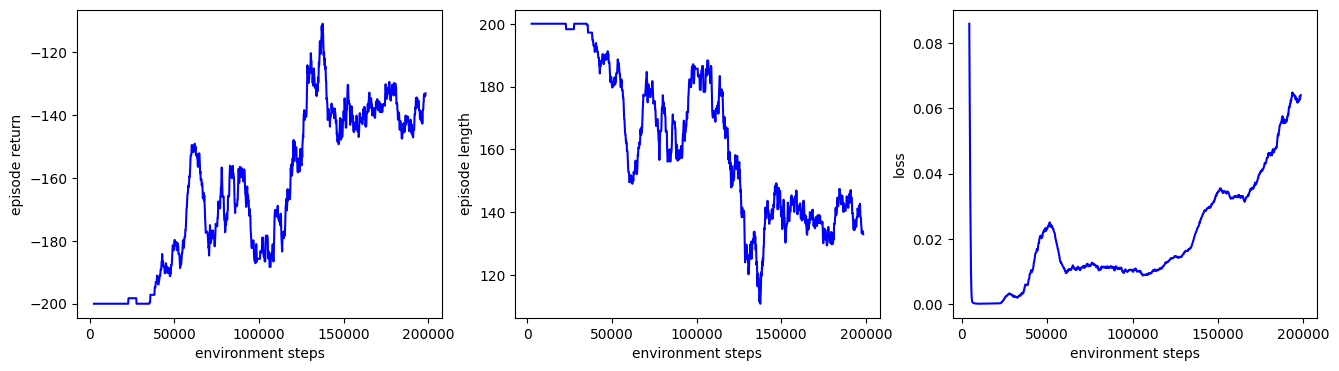

In [20]:
params = default_params()
params['intrinsic_reward'] = True
params['uncertainty_scale'] = 0.001
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]

model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = ExplorationDQNExperiment(params, model, learner=DoubleQLearner(model, params), 
                                      uncertainty=RNDUncertainty(scale=params['uncertainty_scale'], env=env, lr = dnr_lr))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A4.1d) Compare Acrobot-v1 with and without exploration <a id=q4></a>
The `Acrobot-v1` environment requires the agent to learn how to swing up a chain of two connected links. The joint between the two links is (under-) actuated, and swinging the Acrobot can exhibit chaotic behavior. Normally this environment allows episodes of up to 500 steps to ensure the agent sees at least some rewards using random exploration. We make this here a bit harder by restricting episodes to 200 steps (like in `Mountaincar-v0`).
First run double DQN without intrinsic rewards for 200k steps to evaluate whether random exploration is enough to learn in this environment. 

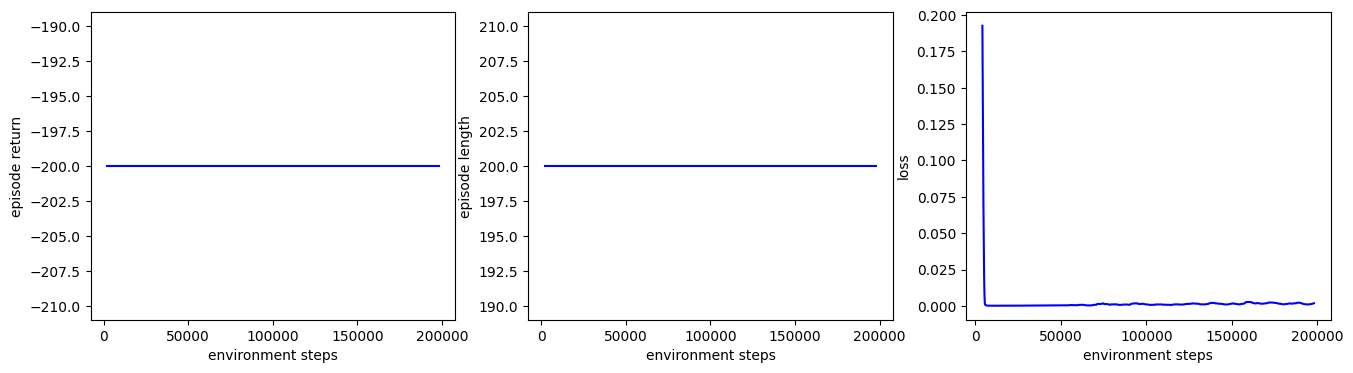

In [39]:
params = default_params()
params['env'] = 'Acrobot-v1'
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = RescaledDQNExperiment(params, model, learner=DoubleQLearner(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close() 
experiment.plot_training()

Next run `Acrobot-v1` with `RNDUncertainty` intrinsic reward. If you do not see similar learning as in `Mountcar-v0`, try to adjust the `uncertainty_scale` with the same techniques as in A4.1c.

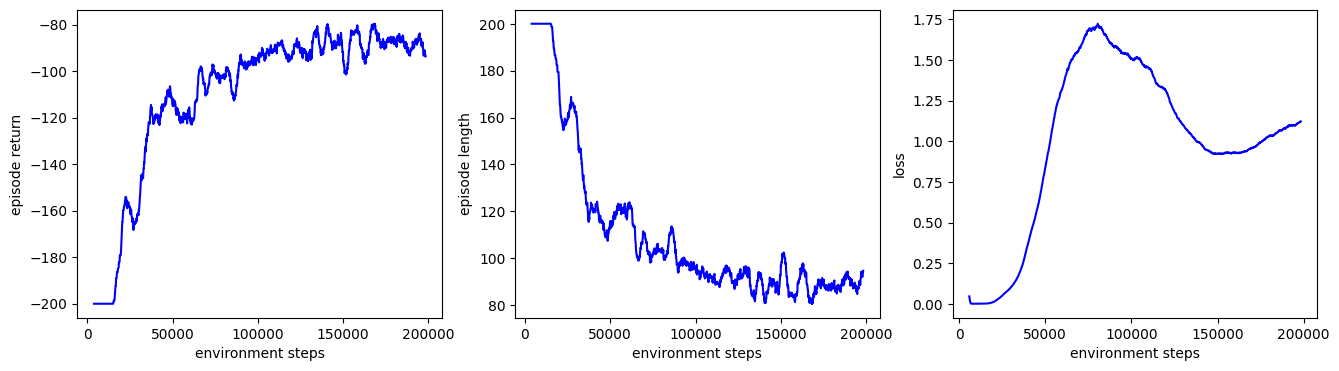

In [42]:
params = default_params()
params['env'] = 'Acrobot-v1'
params['intrinsic_reward'] = True
params['uncertainty_scale'] = 0.0005
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = ExplorationDQNExperiment(params, model, learner=DoubleQLearner(model, params), 
                                      uncertainty=RNDUncertainty(scale=params['uncertainty_scale'], env=env))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()